# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [42]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

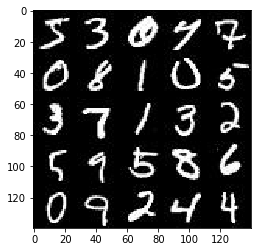

In [43]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

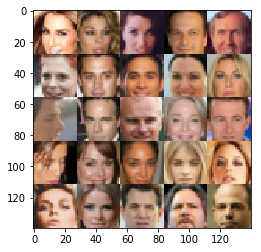

In [44]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [46]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [47]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        flat = tf.reshape(relu3, (-1, 4*4*256))
    
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [48]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        
        x1 = tf.layers.dense(z, 7 * 7 * 256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [49]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1-smooth)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [50]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [51]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [52]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if(data_image_mode == 'RGB'):
        image_channels = 3
    else:
        image_channels = 1
        
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)    
    d_loss,g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_num = 0
    samples, losses = [], []
    
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    saver = tf.train.Saver(var_list=g_vars)  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                                # Sample random noise for G
                
                # Scale images between -1 and 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                # _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,lr:learning_rate})
                batch_num += 1
                
                if (batch_num%100 == 0):
                    show_generator_output(sess=sess,
                                          image_mode=data_image_mode,
                                          input_z=input_z,
                                          n_images=10,
                                          out_channel_dim=image_channels)
            
                # At the end of each epoch, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})

                print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
                # Save losses to view after training
                losses.append((train_loss_d, train_loss_g))

            saver.save(sess, './trainSaver/generator.ckpt')
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 6.0714... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 4.1645... Generator Loss: 0.3932
Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 5.6791
Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 1.8751
Epoch 1/2... Discriminator Loss: 3.9192... Generator Loss: 0.3804
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 7.8326
Epoch 1/2... Discriminator Loss: 4.8256... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 0.6561... Generator Loss: 9.7111
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 6.8711
Epoch 1/2... Discriminator Loss: 6.1731... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 2.4169... Generator Loss: 2.6280
Epoch 1/2... Discriminator Loss: 5.3387... Generator Loss: 0.4969
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 1.5553
Epoch 1/2... Discriminator Loss: 4.1039... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: 2.5791... Generator Loss: 0.9321
Epoch 1/2.

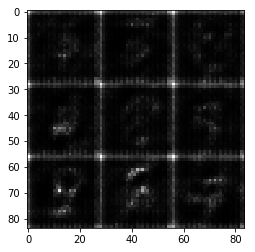

Epoch 1/2... Discriminator Loss: 1.8673... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.8211... Generator Loss: 0.4727
Epoch 1/2... Discriminator Loss: 2.0560... Generator Loss: 0.3939
Epoch 1/2... Discriminator Loss: 1.8532... Generator Loss: 0.4704
Epoch 1/2... Discriminator Loss: 1.9458... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.8816... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.5881... Generator Loss: 0.5363
Epoch 1/2... Discriminator Loss: 1.5032... Generator Loss: 0.6231
Epoch 1/2... Discriminator Loss: 1.7681... Generator Loss: 0.4224
Epoch 1/2... Discriminator Loss: 1.7058... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 1.9578... Generator Loss: 0.3944
Epoch 1/2... Discriminator Loss: 1.7714... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 2.0142... Generator Loss: 0.3761
Epoch 1/2... Discriminator Loss: 1.8177... Generator Loss: 0.8151
Epoch 1/2.

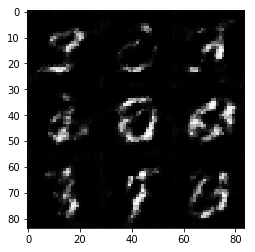

Epoch 1/2... Discriminator Loss: 2.0133... Generator Loss: 0.3865
Epoch 1/2... Discriminator Loss: 1.6626... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.7484... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.6623... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.9592... Generator Loss: 0.3825
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.7586... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.7591... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 1.5093... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.7441... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 1.8584... Generator Loss: 0.4165
Epoch 1/2... Discriminator Loss: 1.7127... Generator Loss: 1.1740
Epoch 1/2... Discriminator Loss: 2.1304... Generator Loss: 0.3593
Epoch 1/2... Discriminator Loss: 1.7534... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.9364... Generator Loss: 0.4088
Epoch 1/2.

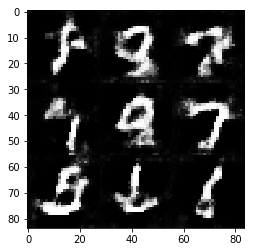

Epoch 1/2... Discriminator Loss: 1.7307... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 1.6945... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.7282... Generator Loss: 0.4183
Epoch 1/2... Discriminator Loss: 1.5866... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.5070... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.7307... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.7379... Generator Loss: 0.4855
Epoch 1/2... Discriminator Loss: 1.6481... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 0.5421
Epoch 1/2... Discriminator Loss: 1.5137... Generator Loss: 0.5698
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.6804... Generator Loss: 0.4687
Epoch 1/2... Discriminator Loss: 1.5743... Generator Loss: 0.7371
Epoch 1/2... Discriminator Loss: 1.6531... Generator Loss: 0.4531
Epoch 1/2.

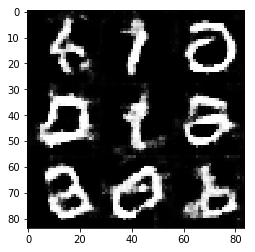

Epoch 1/2... Discriminator Loss: 1.5424... Generator Loss: 0.7140
Epoch 1/2... Discriminator Loss: 1.6639... Generator Loss: 0.4539
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 0.9342
Epoch 1/2... Discriminator Loss: 1.9157... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.6509... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.5461
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.6811... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.5250
Epoch 1/2... Discriminator Loss: 1.4804... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.5600
Epoch 1/2.

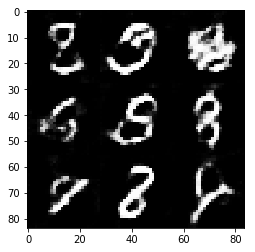

Epoch 1/2... Discriminator Loss: 2.0741... Generator Loss: 0.3757
Epoch 1/2... Discriminator Loss: 1.5578... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 1.6355... Generator Loss: 0.5113
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.6403
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.5896
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.6751
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.5309... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.5795... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 1.6416... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 1.5920... Generator Loss: 0.4914
Epoch 1/2.

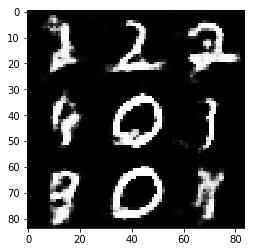

Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.7933... Generator Loss: 0.4312
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.8805
Epoch 1/2... Discriminator Loss: 1.6455... Generator Loss: 0.5201
Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.5931
Epoch 1/2... Discriminator Loss: 1.6887... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.6437... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.5899... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.6088... Generator Loss: 0.5227
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.7509
Epoch 1/2.

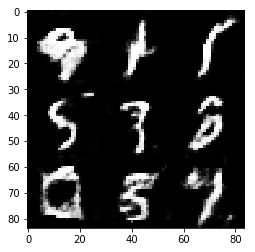

Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.5115
Epoch 1/2... Discriminator Loss: 1.5895... Generator Loss: 0.5191
Epoch 1/2... Discriminator Loss: 1.5616... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.8218
Epoch 1/2... Discriminator Loss: 1.6003... Generator Loss: 0.5476
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.8991
Epoch 1/2... Discriminator Loss: 1.4495... Generator Loss: 0.6131
Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.7898... Generator Loss: 0.4143
Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 1.5092... Generator Loss: 0.5728
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.5334... Generator Loss: 0.5789
Epoch 1/2.

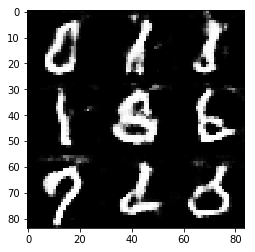

Epoch 1/2... Discriminator Loss: 1.8360... Generator Loss: 0.3980
Epoch 1/2... Discriminator Loss: 1.5464... Generator Loss: 1.2666
Epoch 1/2... Discriminator Loss: 1.6191... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.7096
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.4497... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.6458... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 1.3270... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.6585
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.4654... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.4435... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 0.6190
Epoch 1/2.

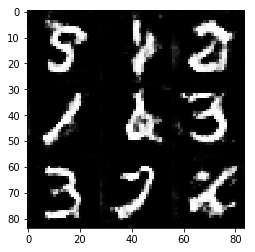

Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 1.5784... Generator Loss: 0.5198
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6322
Epoch 1/2... Discriminator Loss: 1.6805... Generator Loss: 0.4773
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.9477
Epoch 1/2... Discriminator Loss: 1.6830... Generator Loss: 0.4558
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.5814
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.6259... Generator Loss: 0.4651
Epoch 1/2.

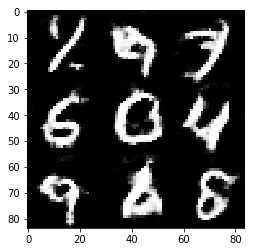

Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.9461
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.5149
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 0.7277
Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.4530
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.7715... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.5096... Generator Loss: 0.5517
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.7915
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.6613
Epoch 1/2... Discriminator Loss: 1.3044... Generator Loss: 0.6389
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.6031
Epoch 1/2.

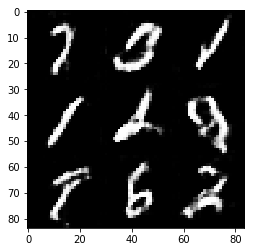

Epoch 1/2... Discriminator Loss: 1.7988... Generator Loss: 0.4109
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.6192
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.6503
Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.5309... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.5621... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.4707
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.7621
Epoch 1/2... Discriminator Loss: 1.6218... Generator Loss: 0.4680
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.7396... Generator Loss: 0.4318
Epoch 1/2.

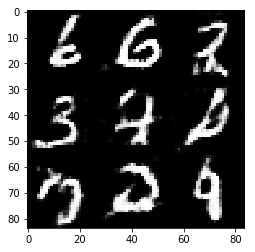

Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.5337
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.9561
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.3031... Generator Loss: 0.6581
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.6991
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.7043
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.8990... Generator Loss: 0.4044
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 1.4443
Epoch 1/2.

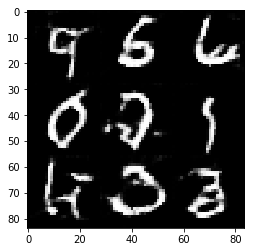

Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.5851
Epoch 1/2... Discriminator Loss: 1.5589... Generator Loss: 0.6300
Epoch 1/2... Discriminator Loss: 1.4348... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.5526
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.5824
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 0.5958
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.5593
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.5900
Epoch 1/2.

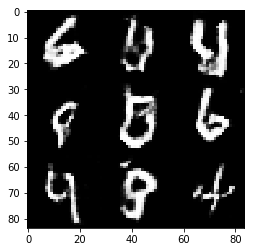

Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.5672
Epoch 1/2... Discriminator Loss: 1.7041... Generator Loss: 0.4585
Epoch 1/2... Discriminator Loss: 1.6438... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.9699
Epoch 1/2... Discriminator Loss: 1.7748... Generator Loss: 0.4322
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 0.9734
Epoch 1/2... Discriminator Loss: 1.8387... Generator Loss: 0.4136
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.6116
Epoch 1/2... Discriminator Loss: 1.4910... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.5227
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.8634
Epoch 1/2.

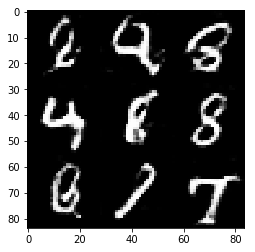

Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.5011
Epoch 1/2... Discriminator Loss: 1.4611... Generator Loss: 0.7560
Epoch 1/2... Discriminator Loss: 1.8078... Generator Loss: 0.4139
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.4918
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.5759
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.1966... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 2.0001... Generator Loss: 0.3824
Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 1.1789
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.5695
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.5662
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 0.7284
Epoch 1/2.

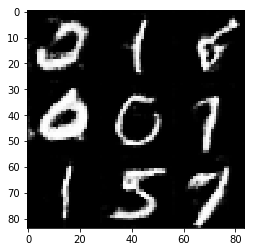

Epoch 1/2... Discriminator Loss: 1.6591... Generator Loss: 0.4798
Epoch 1/2... Discriminator Loss: 1.2905... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 1.5631... Generator Loss: 0.5080
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.5623
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.3903... Generator Loss: 0.6872
Epoch 1/2... Discriminator Loss: 1.6640... Generator Loss: 0.4511
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.5952
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.6335... Generator Loss: 0.4559
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.4931
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.5579... Generator Loss: 0.5598
Epoch 1/2.

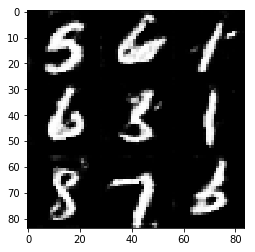

Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.7136... Generator Loss: 0.4517
Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.5371
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 0.9533
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 1.1112... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.9222... Generator Loss: 0.4040
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 1.5113
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 0.7296
Epoch 1/2.

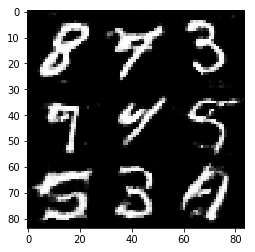

Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.7901... Generator Loss: 0.4434
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.5699
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.6555... Generator Loss: 0.4599
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 1.1325
Epoch 1/2... Discriminator Loss: 1.5958... Generator Loss: 0.4848
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 0.7308
Epoch 1/2... Discriminator Loss: 1.6655... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 1.5425... Generator Loss: 0.5257
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 0.5825
Epoch 1/2.

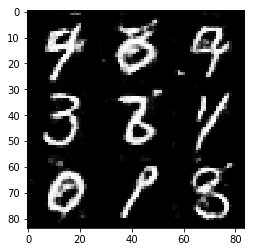

Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.5616
Epoch 2/2... Discriminator Loss: 1.4123... Generator Loss: 0.5898
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 0.5488
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.6115
Epoch 2/2... Discriminator Loss: 1.4678... Generator Loss: 0.5387
Epoch 2/2... Discriminator Loss: 1.1173... Generator Loss: 0.9232
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.6637
Epoch 2/2... Discriminator Loss: 1.5729... Generator Loss: 0.5184
Epoch 2/2... Discriminator Loss: 1.2521... Generator Loss: 0.8777
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.5430... Generator Loss: 0.4867
Epoch 2/2... Discriminator Loss: 1.3816... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.5931... Generator Loss: 0.4967
Epoch 2/2.

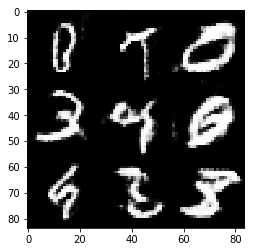

Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.5268
Epoch 2/2... Discriminator Loss: 1.9093... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 1.7278... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 0.5034
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.5670
Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.6332
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.9202... Generator Loss: 0.4067
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 1.1654
Epoch 2/2... Discriminator Loss: 1.7406... Generator Loss: 0.4793
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.2228... Generator Loss: 0.7839
Epoch 2/2... Discriminator Loss: 1.4258... Generator Loss: 0.5294
Epoch 2/2.

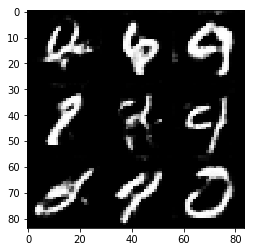

Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.5996
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.1960... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.6425... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.5962
Epoch 2/2... Discriminator Loss: 1.5226... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.0124... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 1.7727... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 1.4836... Generator Loss: 0.5648
Epoch 2/2.

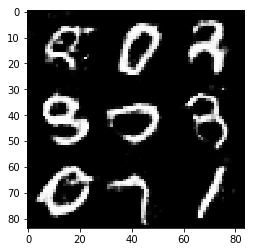

Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 1.1676
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.4961
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.8070
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.5825
Epoch 2/2... Discriminator Loss: 1.5908... Generator Loss: 0.4820
Epoch 2/2... Discriminator Loss: 1.1501... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.7493... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.9386
Epoch 2/2... Discriminator Loss: 1.5655... Generator Loss: 0.4879
Epoch 2/2.

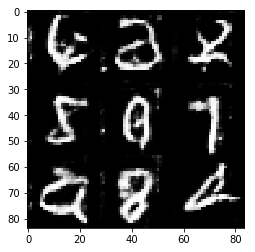

Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 1.2155
Epoch 2/2... Discriminator Loss: 2.0829... Generator Loss: 0.3903
Epoch 2/2... Discriminator Loss: 1.4005... Generator Loss: 0.7023
Epoch 2/2... Discriminator Loss: 1.8610... Generator Loss: 0.4025
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 1.0822
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.6687
Epoch 2/2... Discriminator Loss: 1.2372... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.5672... Generator Loss: 0.5166
Epoch 2/2... Discriminator Loss: 1.2305... Generator Loss: 0.7963
Epoch 2/2... Discriminator Loss: 1.6288... Generator Loss: 0.5488
Epoch 2/2... Discriminator Loss: 1.1974... Generator Loss: 0.8427
Epoch 2/2... Discriminator Loss: 1.5077... Generator Loss: 0.5294
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.7746
Epoch 2/2.

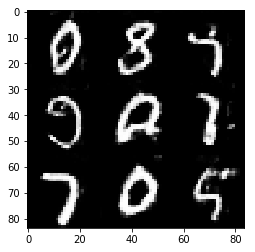

Epoch 2/2... Discriminator Loss: 1.2873... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.2384... Generator Loss: 0.6464
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.1731... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 0.5129
Epoch 2/2... Discriminator Loss: 1.5676... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.8343
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 1.1647... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 1.6348
Epoch 2/2.

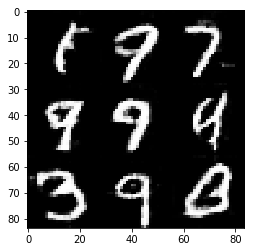

Epoch 2/2... Discriminator Loss: 1.7208... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 1.4565... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 0.6407
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 1.0551
Epoch 2/2... Discriminator Loss: 1.8385... Generator Loss: 0.4219
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.7344... Generator Loss: 0.4454
Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.8936... Generator Loss: 0.4378
Epoch 2/2... Discriminator Loss: 1.7723... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 1.3309... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 1.5772... Generator Loss: 0.4927
Epoch 2/2.

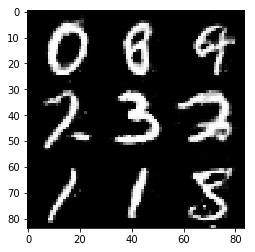

Epoch 2/2... Discriminator Loss: 2.2584... Generator Loss: 0.4232
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.7601... Generator Loss: 0.4574
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 1.0799
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.8382... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 1.6613... Generator Loss: 0.4694
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 1.0978
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.5946
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.7099
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.6265
Epoch 2/2... Discriminator Loss: 1.6057... Generator Loss: 0.5094
Epoch 2/2... Discriminator Loss: 1.9020... Generator Loss: 0.3932
Epoch 2/2.

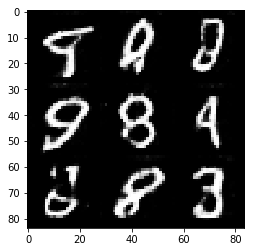

Epoch 2/2... Discriminator Loss: 1.4536... Generator Loss: 0.5578
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 1.1264... Generator Loss: 0.7567
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 1.9684... Generator Loss: 0.4001
Epoch 2/2... Discriminator Loss: 1.8563... Generator Loss: 1.3547
Epoch 2/2... Discriminator Loss: 1.9404... Generator Loss: 0.4161
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 1.2742
Epoch 2/2... Discriminator Loss: 1.8123... Generator Loss: 0.4554
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 1.9191... Generator Loss: 0.4099
Epoch 2/2.

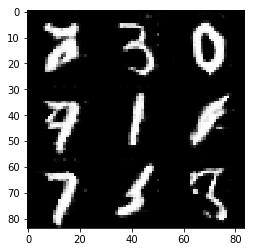

Epoch 2/2... Discriminator Loss: 2.0221... Generator Loss: 0.3974
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 2.4249
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 0.7004
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.5863
Epoch 2/2... Discriminator Loss: 2.0906... Generator Loss: 0.3821
Epoch 2/2... Discriminator Loss: 1.6072... Generator Loss: 1.2375
Epoch 2/2... Discriminator Loss: 2.3013... Generator Loss: 0.3689
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 1.0892
Epoch 2/2... Discriminator Loss: 1.5616... Generator Loss: 0.4960
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.8892
Epoch 2/2... Discriminator Loss: 1.5593... Generator Loss: 0.5167
Epoch 2/2... Discriminator Loss: 1.5012... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.6576
Epoch 2/2.

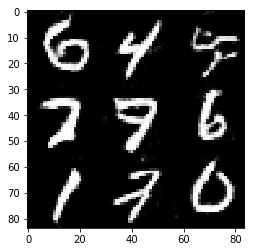

Epoch 2/2... Discriminator Loss: 2.1093... Generator Loss: 1.9925
Epoch 2/2... Discriminator Loss: 2.1098... Generator Loss: 0.4355
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.3680... Generator Loss: 0.8806
Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.4995... Generator Loss: 0.5450
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.8327
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.6334
Epoch 2/2... Discriminator Loss: 1.5190... Generator Loss: 0.5216
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.6335
Epoch 2/2... Discriminator Loss: 1.8693... Generator Loss: 0.4103
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 1.1129
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.6463
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.7649
Epoch 2/2.

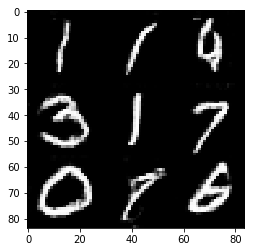

Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 2.2887... Generator Loss: 0.3985
Epoch 2/2... Discriminator Loss: 1.0489... Generator Loss: 1.8670
Epoch 2/2... Discriminator Loss: 1.9143... Generator Loss: 0.4459
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.5458... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 1.5948... Generator Loss: 0.5166
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.5004... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.5260
Epoch 2/2... Discriminator Loss: 1.2772... Generator Loss: 0.6845
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 0.5560
Epoch 2/2.

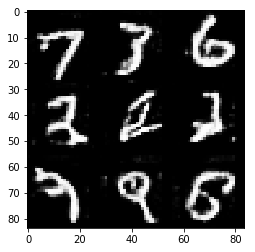

Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.9174
Epoch 2/2... Discriminator Loss: 1.0411... Generator Loss: 0.8592
Epoch 2/2... Discriminator Loss: 1.0638... Generator Loss: 0.9062
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.5929
Epoch 2/2... Discriminator Loss: 1.9227... Generator Loss: 0.4040
Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 1.6042... Generator Loss: 0.4895
Epoch 2/2... Discriminator Loss: 1.9549... Generator Loss: 0.4213
Epoch 2/2... Discriminator Loss: 1.5226... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.6561
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.5982
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.7349
Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.6637
Epoch 2/2.

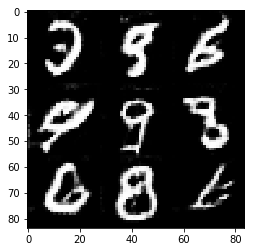

Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.7421
Epoch 2/2... Discriminator Loss: 1.4613... Generator Loss: 0.5575
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 1.2052
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.9432
Epoch 2/2... Discriminator Loss: 1.6464... Generator Loss: 0.4914
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 1.8113... Generator Loss: 0.4745
Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 1.2329
Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.5669
Epoch 2/2.

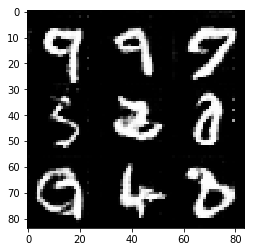

Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.5800
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.6479
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.6604... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 0.6304
Epoch 2/2... Discriminator Loss: 1.6208... Generator Loss: 0.4538
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 2.0315
Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.1379
Epoch 2/2... Discriminator Loss: 1.9882... Generator Loss: 0.4386
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 2.1304
Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.5395
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.9367
Epoch 2/2.

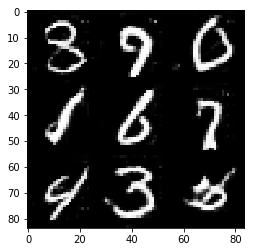

Epoch 2/2... Discriminator Loss: 1.5145... Generator Loss: 0.5269
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 1.5725... Generator Loss: 0.5149
Epoch 2/2... Discriminator Loss: 1.9053... Generator Loss: 0.4171
Epoch 2/2... Discriminator Loss: 1.0764... Generator Loss: 1.1886
Epoch 2/2... Discriminator Loss: 1.8286... Generator Loss: 0.4344
Epoch 2/2... Discriminator Loss: 1.4902... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 1.9913... Generator Loss: 0.4037
Epoch 2/2... Discriminator Loss: 1.2939... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.8019... Generator Loss: 0.4180
Epoch 2/2... Discriminator Loss: 1.2689... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.5407
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.5776
Epoch 2/2.

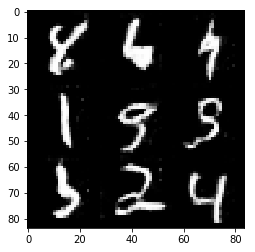

Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.6709
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 1.3027
Epoch 2/2... Discriminator Loss: 1.5344... Generator Loss: 0.5443
Epoch 2/2... Discriminator Loss: 1.1851... Generator Loss: 0.8809
Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.6466
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 1.4765... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.6185... Generator Loss: 0.4779
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.6149
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 0.9371
Epoch 2/2... Discriminator Loss: 1.0027... Generator Loss: 0.9416
Epoch 2/2... Discriminator Loss: 1.6085... Generator Loss: 0.4927
Epoch 2/2... Discriminator Loss: 1.5703... Generator Loss: 0.4971
Epoch 2/2.

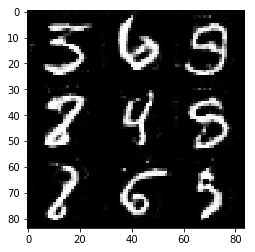

Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 1.4437... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 1.5068... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 1.4948... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 2.5669... Generator Loss: 0.3832
Epoch 2/2... Discriminator Loss: 2.1714... Generator Loss: 2.3305
Epoch 2/2... Discriminator Loss: 1.6134... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.3361... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 2.1141... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 1.9971... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 2.2650... Generator Loss: 0.3902
Epoch 2/2.

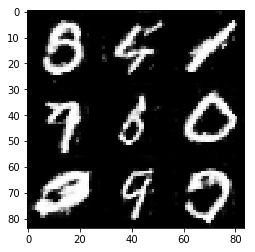

Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.7226... Generator Loss: 0.5161
Epoch 2/2... Discriminator Loss: 1.6011... Generator Loss: 0.5108
Epoch 2/2... Discriminator Loss: 1.3797... Generator Loss: 0.5781
Epoch 2/2... Discriminator Loss: 1.4193... Generator Loss: 0.5479
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.7119
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 1.6626... Generator Loss: 0.5148
Epoch 2/2... Discriminator Loss: 1.5797... Generator Loss: 0.5494
Epoch 2/2... Discriminator Loss: 1.1467... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 2.3308... Generator Loss: 0.3756
Epoch 2/2... Discriminator Loss: 1.7022... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.4047... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.7081... Generator Loss: 0.4428
Epoch 2/2.

In [53]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 4.5293... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 5.1868... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 5.4548... Generator Loss: 0.3693
Epoch 1/1... Discriminator Loss: 4.6963... Generator Loss: 0.4076
Epoch 1/1... Discriminator Loss: 3.2858... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 4.8851... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 3.6018... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 4.6901... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 2.8596... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 5.0366... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 2.0161... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 4.6187... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.8239... Generator Loss: 3.2524
Epoch 1/1... Discriminator Loss: 4.8682... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 3.0358... Generator Loss: 1.9771
Epoch 1/1.

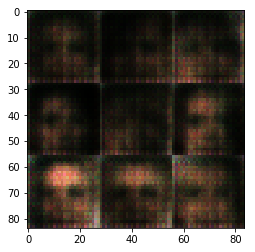

Epoch 1/1... Discriminator Loss: 2.0874... Generator Loss: 0.4139
Epoch 1/1... Discriminator Loss: 1.7489... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 0.4699
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.8304... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.9906... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 2.0528... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 2.0228... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 2.1780... Generator Loss: 0.4625
Epoch 1/1... Discriminator Loss: 1.8211... Generator Loss: 0.5616
Epoch 1/1.

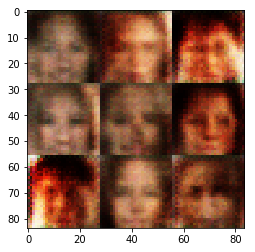

Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.7239... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.8178... Generator Loss: 0.4952
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 2.0068... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.6813... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.6680... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.5022
Epoch 1/1.

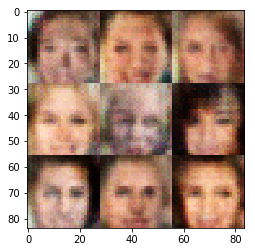

Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.8695... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6754
Epoch 1/1.

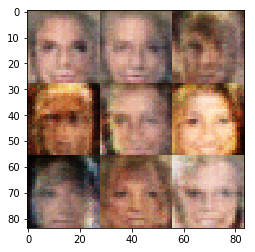

Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.5137... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.5751... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6619
Epoch 1/1.

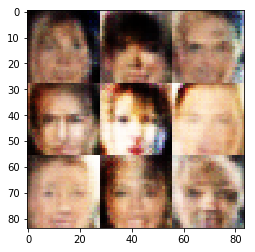

Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.5943... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.6840... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.5917
Epoch 1/1.

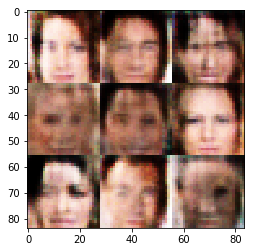

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.6006... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7133
Epoch 1/1.

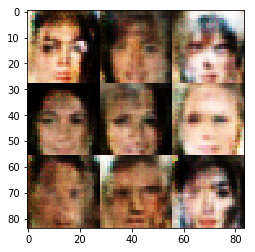

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6783
Epoch 1/1.

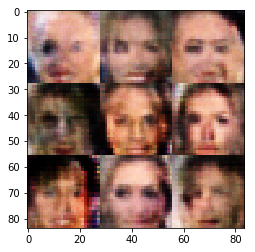

Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.5804... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.5464... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5740... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.5661
Epoch 1/1.

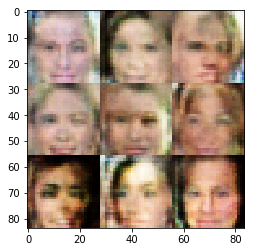

Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6792
Epoch 1/1.

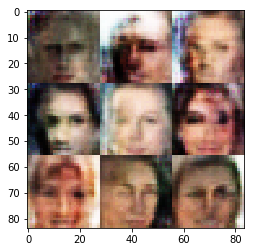

Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8500
Epoch 1/1.

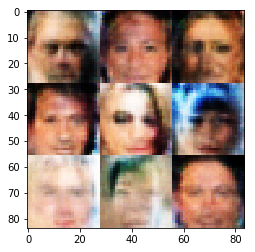

Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.5977
Epoch 1/1.

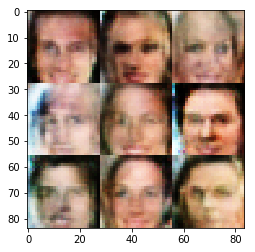

Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.6108... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6234
Epoch 1/1.

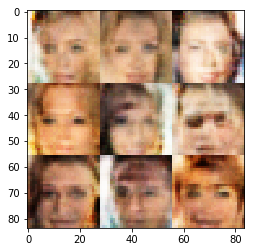

Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.5748... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.6471
Epoch 1/1.

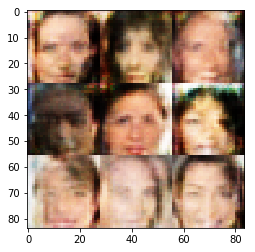

Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7158
Epoch 1/1.

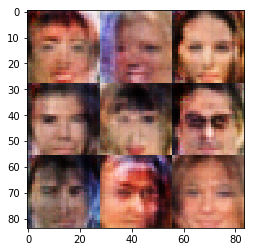

Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.5455... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6742
Epoch 1/1.

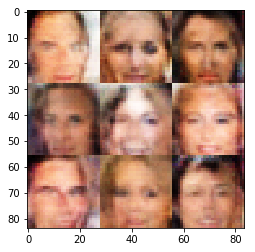

Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6774
Epoch 1/1.

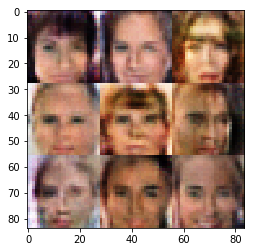

Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7154
Epoch 1/1.

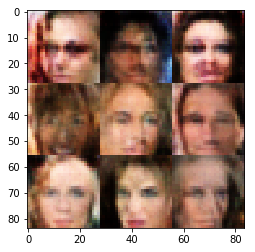

Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6505
Epoch 1/1.

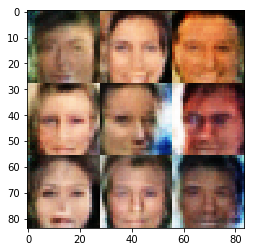

Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.6241
Epoch 1/1.

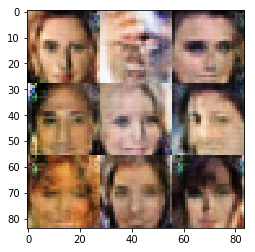

Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.6661
Epoch 1/1.

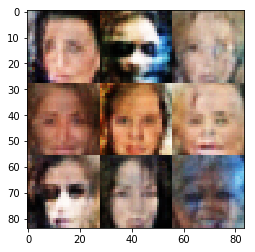

Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6625
Epoch 1/1.

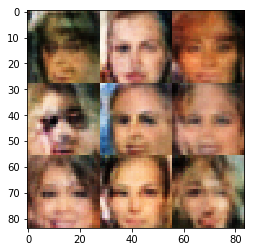

Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.5521... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6721
Epoch 1/1.

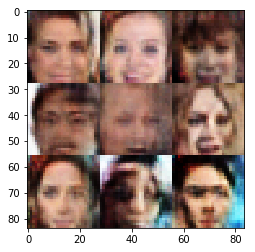

Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.5506... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5370... Generator Loss: 0.6136
Epoch 1/1.

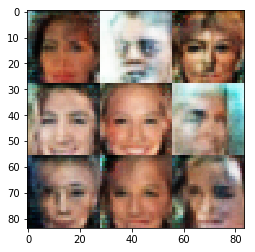

Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.5831... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6334
Epoch 1/1.

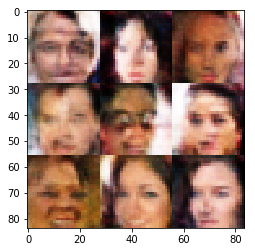

Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.6800
Epoch 1/1.

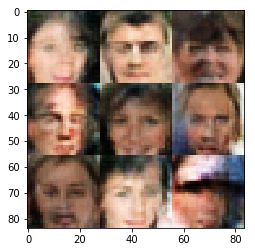

Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4969... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.6562
Epoch 1/1.

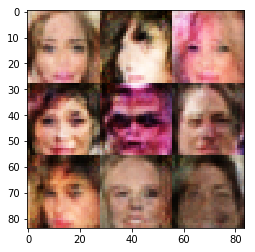

Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5634... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.5651... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.6019
Epoch 1/1.

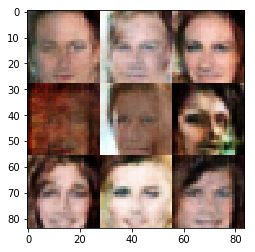

Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.5515... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6336
Epoch 1/1.

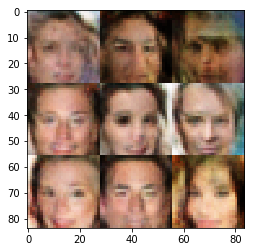

Epoch 1/1... Discriminator Loss: 1.5424... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6348
Epoch 1/1.

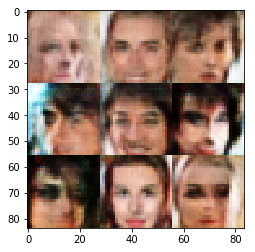

Epoch 1/1... Discriminator Loss: 1.6259... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6607
Epoch 1/1.

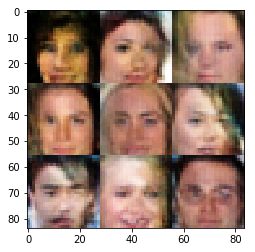

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.6594
Epoch 1/1.

In [54]:

batch_size = 64
z_dim = 200
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。